# Load graph

In [1]:
# !pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html
import networkx as nx
import pandas as pd
import json
import dgl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils

graph, _, labels_data, features_data = utils.load_graph()

g, train_mask, val_mask, test_mask = utils.get_mask(graph)

labels, num_classes = utils.get_labels(labels_data)

# Multinominal Node Classification

### preprocessing: masks, labels, features

In [2]:
naive_feat = utils.get_naive_feat(graph)
property_feat = utils.get_property_feat(graph)
feat = utils.get_real_feat(graph, features_data)

feat.shape

torch.Size([7624, 7842])

### build the GNN and training function

In [12]:
from dgl.nn import SAGEConv

class GNN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")
        self.linear = nn.Linear(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        embeddings = h
        h = self.linear(h)
        return h, embeddings

In [30]:
def train(g,model,features, epochs=100, learning_rate=0.01, early_stopping_rounds=3):
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_val_acc = 0
    best_test_acc = 0
    best_embeddings = []

    statistic = {
        'loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
    }
    
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for e in range(epochs):
        # Forward
        logits, embeddings = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        
        # Compute loss on validation set
        val_loss = F.cross_entropy(logits[val_mask], labels[val_mask])

        #Compute accuracy on training/validation
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        

        # Save loss , val_acc and test_acc
        statistic['loss'].append(loss)
        statistic['val_loss'].append(val_loss)
        statistic['train_acc'].append(train_acc)
        statistic['val_acc'].append(val_acc)

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
            best_embeddings = embeddings

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % (epochs // 10) == 0:
            print(f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}, best {best_test_acc:.3f})")

            # Check for early stopping
            if early_stopping_rounds != 0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= early_stopping_rounds:
                        print(f"Early stopping at epoch {e}")
                        break

    return best_val_acc, best_test_acc, best_embeddings, statistic

### train the models

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is :', device)

hidden_dim = 16
epochs = 500

print(torch.version.cuda)
print(torch.__version__)
g = g.to(device)
labels = labels.to(device)

device is : cuda
12.1
2.1.2


In [36]:
import matplotlib.pyplot as plt

def train_model(ModelClass, feat, hidden_dim, num_classes, graph, epochs, learning_rate, early_stopping_rounds):
    model = ModelClass(feat.shape[1], hidden_dim, num_classes).to(device)
    feat = feat.to(device)
    best_val_acc, best_test_acc, best_embeddings, info = train(graph, model, feat, epochs, learning_rate, early_stopping_rounds)
    return best_val_acc, best_test_acc, best_embeddings, info


def plot_statistics(statistics):
  # plot the loss

  loss_values = [loss.item() for loss in statistics['loss']]
  val_loss_values = [loss.item() for loss in statistics['val_loss']]

  plt.figure()
  plt.plot(loss_values, label='train loss')
  plt.plot(val_loss_values, label='val loss')
  
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

  # plot validation accuracy and test accuracy in the same figure

  train_values = [acc.item() for acc in statistics['train_acc']]
  val_values = [acc.item() for acc in statistics['val_acc']]

  plt.figure()
  plt.plot(train_values, label='train acc')
  plt.plot(val_values, label='val acc')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

def train_wrapper(ModelClass, feat, hidden_dim, num_classes, graph, epochs=100, learning_rate=0.01, early_stopping_rounds=3):
    best_val_acc, best_test_acc, best_embeddings, info = train_model(ModelClass, feat, hidden_dim, num_classes, graph, epochs, learning_rate, early_stopping_rounds)
    plot_statistics(info)
    print(f"Best val acc: {best_val_acc:.3f}, best test acc: {best_test_acc:.3f}")
    return best_embeddings


#### naive model with features all 1

In epoch 0, loss: 3.135, val acc: 0.013 (best 0.013, best 0.025)
In epoch 20, loss: 2.377, val acc: 0.209 (best 0.209, best 0.201)
In epoch 40, loss: 2.365, val acc: 0.209 (best 0.209, best 0.201)
In epoch 60, loss: 2.365, val acc: 0.209 (best 0.209, best 0.201)
In epoch 80, loss: 2.365, val acc: 0.209 (best 0.209, best 0.201)
In epoch 100, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)
In epoch 120, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)
Early stopping at epoch 120


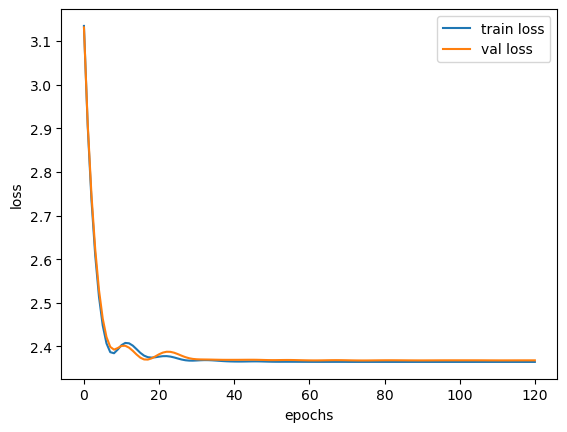

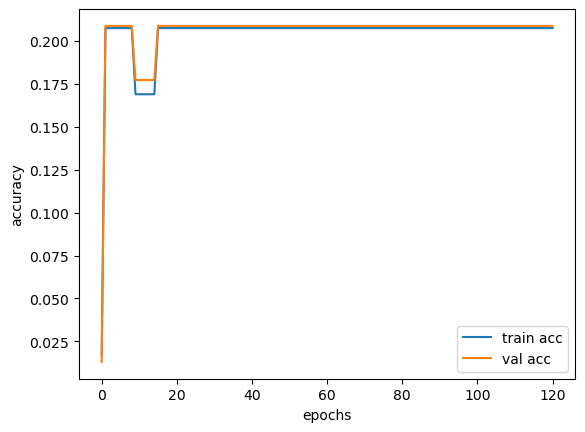

Best val acc: 0.209, best test acc: 0.201


In [37]:
best_embeddings_naive = train_wrapper(GNN, naive_feat, hidden_dim, num_classes, g, epochs=200)

#### model with features being properties

In epoch 0, loss: 26.773, val acc: 0.009 (best 0.009, best 0.012)
In epoch 2000, loss: 1.602, val acc: 0.448 (best 0.453, best 0.464)
In epoch 4000, loss: 1.531, val acc: 0.468 (best 0.474, best 0.485)
In epoch 6000, loss: 1.492, val acc: 0.498 (best 0.498, best 0.493)
In epoch 8000, loss: 1.476, val acc: 0.485 (best 0.507, best 0.513)
In epoch 10000, loss: 1.448, val acc: 0.493 (best 0.511, best 0.512)
Early stopping at epoch 10000


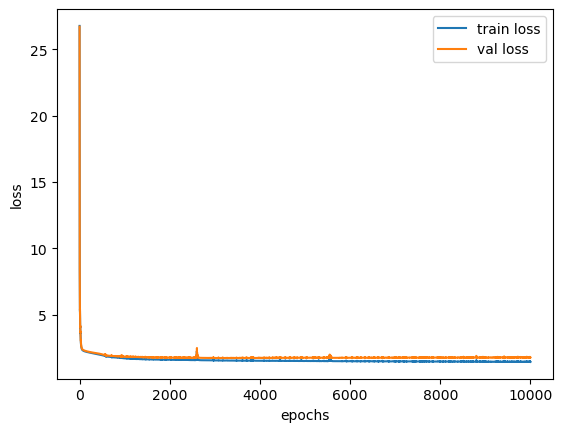

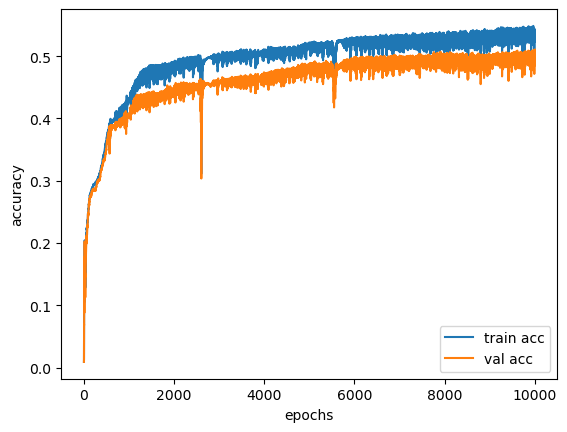

Best val acc: 0.511, best test acc: 0.512


In [41]:


property_feat_embedding = train_wrapper(GNN, property_feat, hidden_dim, num_classes, g, epochs=20000, learning_rate=0.01)

#### model with real features

In epoch 0, loss: 2.947, val acc: 0.068 (best 0.068, best 0.069)
In epoch 50, loss: 0.381, val acc: 0.757 (best 0.757, best 0.745)
In epoch 100, loss: 0.088, val acc: 0.769 (best 0.774, best 0.755)
In epoch 150, loss: 0.032, val acc: 0.760 (best 0.774, best 0.755)
In epoch 200, loss: 0.017, val acc: 0.753 (best 0.774, best 0.755)
Early stopping at epoch 200


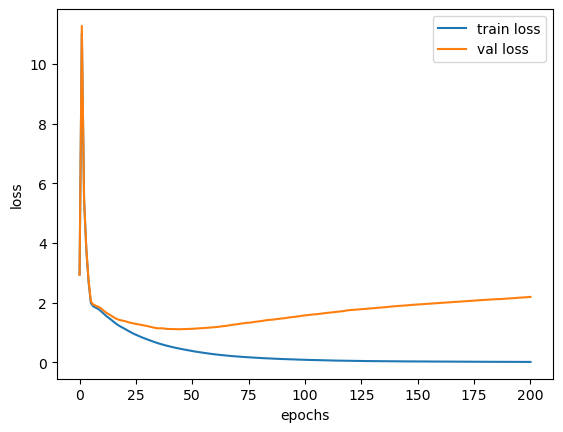

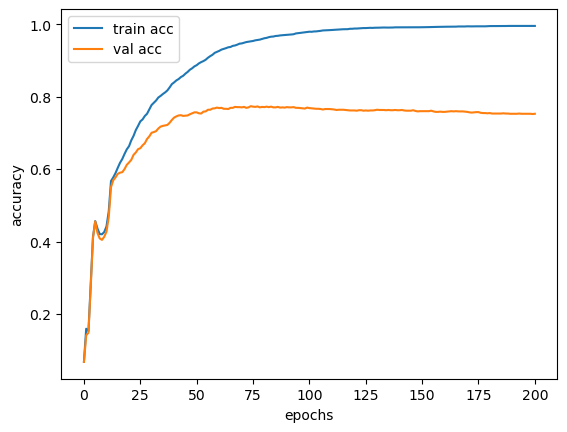

Best val acc: 0.774, best test acc: 0.755


In [40]:
real_feat_embedding = train_wrapper(GNN, feat, hidden_dim, num_classes, g, epochs)

###